# Bank Data: Clean and Transform Loan Prepayment Data For RNN

In [1]:
import pandas as pd
import numpy as np
import pickle
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

Import

In [2]:
df = pickle.load(open('file','rb'))

## Identify a listing of categorical and continuous columns

In [3]:
categorical = []
continuous = []
for col in df.columns.tolist():
    try:
        df[col].astype(float)
        continuous.append(col)
    except:
        categorical.append(col)

In [4]:
# move categorical columns from continuous. Incorrectly classified
for col in ['NewLoan','Final_Payment']:
    categorical.append(col)
    continuous.remove(col)

# as of date and account number cannot be kept in categorical because of the creation of the dummy variables
# we will subset by bank, create sequences arrays out of the account numbers and the sequence times will be the
# as of dates
for col in ['As_Of_Date', 'Account_Number']:
    continuous.append(col)
    categorical.remove(col)

In [5]:
df[categorical]
dates = ['As_Of_Date','Maturity_Date','Next_Repricing_Date','Next_Payment_Date',\
         'Prior_Maturity_Date','Prior_Origination_Date']

# we want to keep prior origination date as it is the only origionation date we have
delete = [x for x in categorical if 'Prior' in x and x !='Prior_Origination_Date']
delete

['Prior_Maturity_Date',
 'Prior_Payment_Fequency',
 'Prior_Next_Reprice_Date',
 'Prior_Branch',
 'Prior_LOC_Code']

## Check  dates

In [6]:
display(df[dates[2:]].head())
df[dates].info()

,Next_Repricing_Date,Next_Payment_Date,Prior_Maturity_Date,Prior_Origination_Date
0,2014-01-23 00:00:00.000,2009-04-23 00:00:00.000,2024-01-23 00:00:00.000,2004-01-23 00:00:00.000
1,NaN,2009-04-10 00:00:00.000,NaN,NaN
2,2012-10-26 00:00:00.000,2009-04-26 00:00:00.000,2027-10-26 00:00:00.000,2007-10-26 00:00:00.000
3,2016-05-05 00:00:00.000,2009-04-05 00:00:00.000,2031-05-05 00:00:00.000,2006-05-05 00:00:00.000
4,2009-11-23 00:00:00.000,2009-04-23 00:00:00.000,2019-11-23 00:00:00.000,2004-11-23 00:00:00.000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 649729 entries, 0 to 47690
Data columns (total 6 columns):
As_Of_Date                649729 non-null datetime64[ns]
Maturity_Date             649729 non-null datetime64[ns]
Next_Repricing_Date       308621 non-null object
Next_Payment_Date         647644 non-null object
Prior_Maturity_Date       599344 non-null object
Prior_Origination_Date    599337 non-null object
dtypes: datetime64[ns](2), object(4)
memory usage: 34.7+ MB


Remove dates that are not as of date, maturity date, and Origination date along with the priors

In [7]:
print('the shape of df before we remove the columns: ', df.shape)
delete.extend(['Next_Repricing_Date','Next_Payment_Date'])
print('we will remove {} columns from the df'.format(len(delete)))
df = df.loc[:,~df.columns.isin(delete)]
print('the shape of the df after we remove the columns: ', df.shape)

the shape of df before we remove the columns:  (649729, 89)
we will remove 7 columns from the df
the shape of the df after we remove the columns:  (649729, 82)


In [8]:
# remove the delete variables and dates from the categorical list
categorical = [x for x in categorical if x not in delete]
categorical = [x for x in categorical if x not in dates]

# Clean the categorical variables

In [9]:
for col in categorical:
    print(col)
    print(df[col].unique(),'\n')
    print('-------------------')

PrepayClassCode
['CRE' 'C & I' 'Construction'] 

-------------------
Fixed/Adjustable
['Adjustable' 'Fixed' 'Floating'] 

-------------------
Term_Structure
['60M' '3YR' '<24M' '10YR' '5YR' '1M' '36M' '1YR' '3M' '6M' nan 'else'] 

-------------------
Original_Term_Range
['>120' '<36' '36-60' '60-120' '<12' '<120' '12-36' '121-180' '241-300'
 '>300' '181-240' 'Dec-36'] 

-------------------
Loan_Age_Range
['49-60' '<12' '13-24' '25-36' '61-120' '37-48' '>120'] 

-------------------
Reprice_Term
['<6' '36-48' '>60' '6-12' '48-60' '24-36' '12-24' '12-Jun' '24-Dec'] 

-------------------
Classification_Code
['Commercial RE' 'C & I' 'Residential - Constr' 'Commercial RE - Constr'
 'C & I '] 

-------------------
Repricing_Code
['Adjustable' 'Fixed' 'Floating'] 

-------------------
Payment_Frequency_Code
['Monthly' 'Annual' 'Quarterly' 'Semi-Annual' 'Weekly' 'At Maturity'
 'Bi-Weekly' 'None' 'Semi-Monthly'] 

-------------------
Current_Index_Code
['LR03' 'NONE' 'LR08' 'PRIME' 'LIBOR01MO' '

1. Term_Structure {'36M' : '3YR'}, {'60M' : '5YR'}
2. Remove Dates
3. remove Original_Term_Range
4. remove Current_Index_Code
5. remove LOC_Code
6. remove Class_Code - According the dictionary, this is redundant with Type_Code
7. remove Collateral_Code - all nulls
8. remove Custom_Tag_1 & Custom_Tag_3 - neither has an originating signal
9. remove Final_Payment 
10. remove Originating_Branch
10. remove NewLoan

Remove:

In [10]:
delete = ['Maturity_Date','Original_Term_Range','Current_Index_Code','LOC_Code',\
          'Class_Code','Collateral_Code','Custom_Tag_1', 'Custom_Tag_3','Final_Payment',\
          'Originating_Branch','NewLoan']

categorical = [x for x in categorical if x not in delete]
print(df.shape)
print(len(delete))
df = df.loc[:,~df.columns.isin(delete)]
print(df.shape)

(649729, 82)
11
(649729, 71)


Fix Term_Structure:

In [11]:
df.loc[df.Term_Structure == '36M','Term_Structure'] = '3YR'
df.loc[df.Term_Structure == '60M','Term_Structure'] = '5YR'

Remove items from the continuous

In [12]:
continuous = [x for x in continuous if x not in ['Bank','As_Of_Date','Account_Number']]

In [13]:
#Temp remove state_indicators.
# state_indicators = ['st_House_Price_Index', 'st_Unemploy_Rate', 'st_All_Private_Employees', 'st_Retail_Trade_Earnings', 'st_All_Emp_Construction', 'st_Construction_Earnings', 'st_State_Leading_Index', 'st_Coincident_Econ_Activity_Index', 'st_Avg_Hourly_Earnings_Private']
# national_indicators = [ 'US_GDP_Growth', 'Pers_Savings_Rate', 'USLeading_Index', 'Corp_Profits', 'Initial_Claims', 'Unemp_Rate', 'Schiller_House_Index', 'Comm_RE_Price_Index', 'Tot_Construction_Spending', 'VIX', 'Personal_Consumption_Exp', 'Personal_Income', 'New_Home_Sales', 'BBB_Corp_Yield', 'Mortgage_Rate', 'Prime_Rate', 'CPI', 'Real_Disp_Income', 'Stock Market']
# rel_rates = ['Relevant_Rate', 'Relevant_Rate_Diff']
# continuous = [x for x in continuous if x not in state_indicators]
# continuous = [x for x in continuous if x not in national_indicators]
# continuous = [x for x in continuous if x not in rel_rates]

In [14]:
print(continuous)

['Original_Term', 'Current_Interest_Rate', 'Interest_Margin', 'Lifetime_Rate_Cap', 'Lifetime_Rate_Floor', 'Interest_Rate_Change_Frequency', 'Actual_Payment', 'Expected_Payment', 'Gross_Prepayment', 'Missed_Payment', 'P_&_I_Payment', 'Curtailment', 'Draws', 'Total_Prepayment', 'Modification', 'Refinance', 'PayOff', 'CPR', 'Prior_Quarter_Balance', 'Balance_Owned_Participation', 'Prior_Interest_Rate', 'Prior_Internal_Credit_Rating', 'Internal_Credit_Rating', 'Quarters_Remaining', 'Relevant_Rate', 'Relevant_Rate_Diff', 'US_GDP_Growth', 'Pers_Savings_Rate', 'USLeading_Index', 'Corp_Profits', 'Initial_Claims', 'Unemp_Rate', 'Schiller_House_Index', 'Comm_RE_Price_Index', 'Tot_Construction_Spending', 'VIX', 'Personal_Consumption_Exp', 'Personal_Income', 'New_Home_Sales', 'BBB_Corp_Yield', 'Mortgage_Rate', 'Prime_Rate', 'CPI', 'Real_Disp_Income', 'Stock Market', 'st_House_Price_Index', 'st_Unemploy_Rate', 'st_All_Private_Employees', 'st_Retail_Trade_Earnings', 'st_All_Emp_Construction', 'st_Con

Remove 'prior' columns from the data frame

In [15]:
df = df.loc[:,~df.columns.isin(['Prior_Interest_Rate', 'Prior_Origination_Date','Prior_Internal_Credit_Rating'])]

## Assess and remove nulls

In [16]:
pd.isnull(df).sum()

Bank                                      0
As_Of_Date                                0
Account_Number                            0
PrepayClassCode                           0
Fixed/Adjustable                          0
Term_Structure                        23056
Original_Term                            23
Loan_Age_Range                            0
Current_Interest_Rate                     0
Interest_Margin                           0
Lifetime_Rate_Cap                         0
Lifetime_Rate_Floor                       0
Interest_Rate_Change_Frequency            0
Reprice_Term                              0
Actual_Payment                            0
Expected_Payment                          0
Gross_Prepayment                          0
Missed_Payment                            0
P_&_I_Payment                             0
Curtailment                               0
Draws                                     0
Total_Prepayment                          0
Modification                    

I will determine which loans are missing the Original_Term and remove those loans. Otherwise, all excessive null columns will be deleted

In [17]:
ot_null = df.loc[pd.isnull(df.Original_Term),'Account_Number'].unique().tolist()
df.loc[df.Account_Number.isin(ot_null)].shape

(200, 68)

We will loose 200 lines of data by removing these. I am okay with that.

In [18]:
df = df.loc[~df.Account_Number.isin(ot_null),:].reset_index(drop = True)
df.shape

(649529, 68)

Drop Excessive NA columns:

In [19]:
# Get the columns with nulls
null_cols = pd.isnull(df).sum()[pd.isnull(df).sum()>0].index.tolist()
null_cols

['Term_Structure',
 'Multi_Family_Code',
 'Custom_Tag_2',
 'Internal_Credit_Rating',
 'US_GDP_Growth',
 'Comm_RE_Price_Index',
 'st_Avg_Hourly_Earnings_Private']

In [20]:
indicators = ['US_GDP_Growth','Comm_RE_Price_Index','st_Avg_Hourly_Earnings_Private']
del_cols = ['Term_Structure','Multi_Family_Code','Custom_Tag_2','Internal_Credit_Rating']

# Salvage Indicator Data
Some of the indicators do not go back to 2003. However, it is very important that we have this information. I will remove the old dates to salvage this information.

In [21]:
min_date = []
for col in indicators:
    min_date.append(max(df.loc[pd.isnull(df[col]),'As_Of_Date']))
    
pd.DataFrame({'Feature': indicators, 'Max_Date':min_date}).sort_values(by='Max_Date')

,Feature,Max_Date
1,Comm_RE_Price_Index,2004-12-31
0,US_GDP_Growth,2005-03-31
2,st_Avg_Hourly_Earnings_Private,2006-12-31


To keep these indicators, I will remove data as of dates before 2006.

In [22]:
print(df.shape)
df = df.loc[df.As_Of_Date.dt.year > 2006,:]
print(df.shape)

(649529, 68)
(643610, 68)


In [ ]:
df

In [24]:
# remove null cols from the categorical and continuous listings
continuous = [x for x in continuous if x not in del_cols + ['Prior_Interest_Rate', 'Prior_Origination_Date','Prior_Internal_Credit_Rating']]
categorical = [x for x in categorical if x not in del_cols]

## remove nulls

In [25]:
df = df.dropna(axis=1, how='any')
print(df.shape)
pd.isnull(df).sum()

(643610, 64)


Bank                                 0
As_Of_Date                           0
Account_Number                       0
PrepayClassCode                      0
Fixed/Adjustable                     0
Original_Term                        0
Loan_Age_Range                       0
Current_Interest_Rate                0
Interest_Margin                      0
Lifetime_Rate_Cap                    0
Lifetime_Rate_Floor                  0
Interest_Rate_Change_Frequency       0
Reprice_Term                         0
Actual_Payment                       0
Expected_Payment                     0
Gross_Prepayment                     0
Missed_Payment                       0
P_&_I_Payment                        0
Curtailment                          0
Draws                                0
Total_Prepayment                     0
Modification                         0
Refinance                            0
PayOff                               0
CPR                                  0
Prior_Quarter_Balance    

# Remove variables that will result in a function of y in our x space. 
1. keep expected payment and actual payments
2. remove the variables with a direct correlation with the prepayment


# ADDITIONAL FLAGS
1. Flag for type of prepayment. 
2. Previous large prepayment flag

In [26]:
remove = ['Gross_Prepayment']

y = 'Total_Prepayment'

# remove the columns from the dataframe
df = df.loc[:,~df.columns.isin(remove)]

# remove the columns from the continuous list 
continuous = [x for x in continuous if x not in remove + [y]]

In [27]:
continuous

['Original_Term',
 'Current_Interest_Rate',
 'Interest_Margin',
 'Lifetime_Rate_Cap',
 'Lifetime_Rate_Floor',
 'Interest_Rate_Change_Frequency',
 'Actual_Payment',
 'Expected_Payment',
 'Missed_Payment',
 'P_&_I_Payment',
 'Curtailment',
 'Draws',
 'Modification',
 'Refinance',
 'PayOff',
 'CPR',
 'Prior_Quarter_Balance',
 'Balance_Owned_Participation',
 'Quarters_Remaining',
 'Relevant_Rate',
 'Relevant_Rate_Diff',
 'US_GDP_Growth',
 'Pers_Savings_Rate',
 'USLeading_Index',
 'Corp_Profits',
 'Initial_Claims',
 'Unemp_Rate',
 'Schiller_House_Index',
 'Comm_RE_Price_Index',
 'Tot_Construction_Spending',
 'VIX',
 'Personal_Consumption_Exp',
 'Personal_Income',
 'New_Home_Sales',
 'BBB_Corp_Yield',
 'Mortgage_Rate',
 'Prime_Rate',
 'CPI',
 'Real_Disp_Income',
 'Stock Market',
 'st_House_Price_Index',
 'st_Unemploy_Rate',
 'st_All_Private_Employees',
 'st_Retail_Trade_Earnings',
 'st_All_Emp_Construction',
 'st_Construction_Earnings',
 'st_State_Leading_Index',
 'st_Coincident_Econ_Activit

# Export Clean Data Frame to Pickle

In [28]:
# pickle.dump(df, open('FILE/df_clean_final.p','wb'))
# pickle.dump(continuous,open('FILE/continuous.p','wb'))
# pickle.dump(categorical,open('FILE/categorical.p','wb'))

# <font color = green> Checkpoint </font>
==============================================<br>
Import the below files and continue here......

In [29]:
import pandas as pd
import numpy as np
import pickle
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)

# files
# ----------------------------------------
file = 'your_file_path'
file1 = 'your_file_path'

# df = pickle.load(open(file1 + 'df_clean_final.p','rb'))
# continuous = pickle.load(open(file + 'continuous.p','rb'))
# categorical = pickle.load(open(file + 'categorical.p','rb'))
small_long = pickle.load(open(file + 'small_balance_short_list.p','rb'))
large_long = pickle.load(open(file + 'large_balance_long_list.p','rb'))
large_short = pickle.load(open(file + 'large_balance_short_list.p','rb'))
small_long = pickle.load(open(file + 'small_balance_long_list.p','rb'))

# Remove Accounts with Only One Observation
# -----------------------------------------
act_count = df.Account_Number.value_counts()
one_act = act_count[act_count==1].index.tolist()
df = df[~df.Account_Number.isin(one_act)].reset_index(drop = True)


# Revise the feature listings
# ---------------------------
# remove the type code
categorical = [x for x in categorical if x not in 'Type_Code']

# duplicate total prepayemnt - This will not be standardized. Prepayment will.
# We need to standardize the Total Prepayment when it is a Previous Total Prepayment. 
df['Response'] = df.Total_Prepayment
continuous.append('Total_Prepayment')

# Confirm Variable Listing Variables
print('Categorical Variables')
print('---------------------')
print(categorical)
print('\n')
print('Continuous Variables')
print('---------------------')
print(continuous)

Categorical Variables
---------------------
['PrepayClassCode', 'Fixed/Adjustable', 'Loan_Age_Range', 'Reprice_Term', 'Classification_Code', 'Repricing_Code', 'Payment_Frequency_Code', 'Interest/Principal_Only_Code', 'Repricing_Frequency_Code']


Continuous Variables
---------------------
['Original_Term', 'Current_Interest_Rate', 'Interest_Margin', 'Lifetime_Rate_Cap', 'Lifetime_Rate_Floor', 'Interest_Rate_Change_Frequency', 'Actual_Payment', 'Expected_Payment', 'Missed_Payment', 'P_&_I_Payment', 'Curtailment', 'Draws', 'Modification', 'Refinance', 'PayOff', 'CPR', 'Prior_Quarter_Balance', 'Balance_Owned_Participation', 'Quarters_Remaining', 'Relevant_Rate', 'Relevant_Rate_Diff', 'US_GDP_Growth', 'Pers_Savings_Rate', 'USLeading_Index', 'Corp_Profits', 'Initial_Claims', 'Unemp_Rate', 'Schiller_House_Index', 'Comm_RE_Price_Index', 'Tot_Construction_Spending', 'VIX', 'Personal_Consumption_Exp', 'Personal_Income', 'New_Home_Sales', 'BBB_Corp_Yield', 'Mortgage_Rate', 'Prime_Rate', 'CPI', '

# Isolate Subset

In [30]:
# Isolate the subset
df = df[df.Account_Number.isin(small_long.Account_Number.tolist())]
print(df.shape,'\n')

(268038, 64) 



# Encode Categorical Variables

In [31]:
df.head()

,Bank,As_Of_Date,Account_Number,PrepayClassCode,Fixed/Adjustable,Original_Term,Loan_Age_Range,Current_Interest_Rate,Interest_Margin,Lifetime_Rate_Cap,Lifetime_Rate_Floor,Interest_Rate_Change_Frequency,Reprice_Term,Actual_Payment,Expected_Payment,Missed_Payment,P_&_I_Payment,Curtailment,Draws,Total_Prepayment,Modification,Refinance,PayOff,CPR,Prior_Quarter_Balance,Balance_Owned_Participation,Classification_Code,Repricing_Code,Payment_Frequency_Code,Type_Code,Interest/Principal_Only_Code,Repricing_Frequency_Code,Quarters_Remaining,Relevant_Rate,Relevant_Rate_Diff,US_GDP_Growth,Pers_Savings_Rate,USLeading_Index,Corp_Profits,Initial_Claims,Unemp_Rate,Schiller_House_Index,Comm_RE_Price_Index,Tot_Construction_Spending,VIX,Personal_Consumption_Exp,Personal_Income,New_Home_Sales,BBB_Corp_Yield,Mortgage_Rate,Prime_Rate,CPI,Real_Disp_Income,Stock Market,st_House_Price_Index,st_Unemploy_Rate,st_All_Private_Employees,st_Retail_Trade_Earnings,st_All_Emp_Construction,st_Construction_Earnings,st_State_Leading_Index,st_Coincident_Econ_Activity_Index,st_Avg_Hourly_Earnings_Private,Response
2,1,2009-03-31,1178103815,CRE,Adjustable,240.000,13-24,7.950,3.100,0.000,0.000,60.000,36-48,351.760,352.100,0.330,504.370,0.000,0.000,0.000,0.000,0.000,0.000,0.000,58532.640,58180.870,Commercial RE,Adjustable,Monthly,215,Principal/Interest Off,60M,74.000,3.200,4.750,-5.400,6.100,-2.790,1044.256,665000.000,8.700,146.527,-12.900,958519.000,44.140,9770.222,12000.500,311.000,9.430,4.850,3.250,-0.498,-0.800,30.510,493.950,8.000,494.700,2710232.000,25.900,2370784.000,-2.030,129.000,19.100,0.000
3,1,2009-03-31,5078098599,CRE,Adjustable,300.000,25-36,7.750,6.750,0.000,0.000,60.000,>60,305.550,305.900,0.350,549.310,0.000,0.000,0.000,0.000,0.000,0.000,0.000,69367.840,69062.290,Commercial RE,Adjustable,Monthly,215,Principal/Interest Off,60M,88.000,3.240,4.510,-5.400,6.100,-2.790,1044.256,665000.000,8.700,146.527,-12.900,958519.000,44.140,9770.222,12000.500,311.000,9.430,4.850,3.250,-0.498,-0.800,30.510,493.950,8.000,494.700,2710232.000,25.900,2370784.000,-2.030,129.000,19.100,0.000
4,1,2009-03-31,117890431,CRE,Adjustable,180.000,49-60,6.500,5.500,0.000,0.000,60.000,6-12,358.130,394.900,36.760,261.340,0.000,0.000,0.000,0.000,0.000,0.000,0.000,24409.200,24051.060,Commercial RE,Adjustable,Monthly,215,Principal/Interest Off,60M,42.000,2.860,3.640,-5.400,6.100,-2.790,1044.256,665000.000,8.700,146.527,-12.900,958519.000,44.140,9770.222,12000.500,311.000,9.430,4.850,3.250,-0.498,-0.800,30.510,493.950,8.000,494.700,2710232.000,25.900,2370784.000,-2.030,129.000,19.100,0.000
11,1,2009-03-31,6101342,CRE,Fixed,180.000,61-120,8.500,0.000,0.000,0.000,1.000,<6,1027.910,1051.300,23.390,436.460,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12493.360,11465.450,Commercial RE,Fixed,Monthly,201,Principal/Interest Off,1M,31.000,2.560,5.940,-5.400,6.100,-2.790,1044.256,665000.000,8.700,146.527,-12.900,958519.000,44.140,9770.222,12000.500,311.000,9.430,4.850,3.250,-0.498,-0.800,30.510,493.950,8.000,494.700,2710232.000,25.900,2370784.000,-2.030,129.000,19.100,0.000
13,1,2009-03-31,4402093676,CRE,Fixed,120.000,37-48,10.500,0.000,0.000,0.000,1.000,<6,262.290,474.050,211.760,315.940,0.000,0.000,0.000,0.000,0.000,0.000,0.000,18456.070,18193.780,Commercial RE,Fixed,Monthly,201,Principal/Interest Off,1M,25.000,2.400,8.100,-5.400,6.100,-2.790,1044.256,665000.000,8.700,146.527,-12.900,958519.000,44.140,9770.222,12000.500,311.000,9.430,4.850,3.250,-0.498,-0.800,30.510,493.950,8.000,494.700,2710232.000,25.900,2370784.000,-2.030,129.000,19.100,0.000


Create Dummies for Categorical Variables first. 

In [32]:
# declare y variable
y = 'Response'

# order by as of date and reset the index
df = df.sort_values(by = 'As_Of_Date').reset_index(drop = True)

#subset continuous
cont_df = df.loc[:,continuous +['As_Of_Date', 'Account_Number'] + [y]]

# create dummy variables for the categorical variables
dummies = pd.get_dummies(df[categorical].astype(str))

# create the data frame
df = pd.merge(cont_df, dummies, how = 'left', left_index=True, right_index = True)
df.shape

(268038, 105)

Since the sequences are of different lengths for different accounts, we will need to pad the account accounts with leading zeros to fit into a 3d tensor. I will determine what is the max sequence length.

https://stackoverflow.com/questions/45012992/how-to-prepare-data-for-lstm-when-using-multiple-time-series-of-different-length?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

Subset into bank 4 and bank 6

Determine the distribution of the length of sequences to see where to set the max sequences as

The max sequence length for all accounts:  43


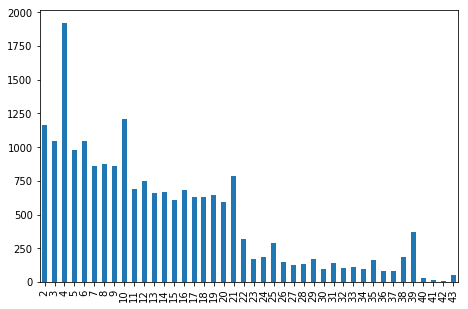

In [33]:
groups = df.groupby('Account_Number')
max_len = 0
seq_lengths = []
account_nums = []
for account, group in groups:
    account_nums.append(account)
    seq_lengths.append(group.shape[0])
    max_len = np.max([max_len, group.shape[0]])
    
print('The max sequence length for all accounts: ', max_len)
pd.Series(seq_lengths).value_counts().sort_index().plot(kind = 'bar', figsize=(7.5,5))

It  appears there is a drop off loans affected at seqence length of 22. Additionally,almost have the loans have a duration of less than 3 quarters. I will keep the sorter seqences but remove those over 22. If we have poor predictions we may want to consider removing sequences less than 3 or 4. Want to determine how many loans we are working with.

In [34]:
# create a df of sequence lenghts
df_acct_seqlen = pd.DataFrame({'Account_Number':account_nums, 'Seq_Len':seq_lengths})

#sort by sequence length 
df_acct_seqlen = df_acct_seqlen.sort_values(by='Seq_Len').reset_index(drop = True)
display(df_acct_seqlen.head(10))

# get the account numbers with seqence lengths greater than 22
trunc_accts = df_acct_seqlen.loc[df_acct_seqlen.Seq_Len>22,'Account_Number'].tolist()
print('There are {} accounts with sequences that exceed 22.'.format(len(trunc_accts)))
print('Truncating these accounts will affect {} lines of data in bank 4'.format(
       df[df.Account_Number.isin(trunc_accts)].shape[0] - (len(trunc_accts)*22)))

,Account_Number,Seq_Len
0,5700625313,2
1,3502094900,2
2,600082868,2
3,1153709,2
4,603291642,2
5,604948456,2
6,604968756,2
7,6101897,2
8,600082124,2
9,6181139092,2


There are 2764 accounts with sequences that exceed 22.
Truncating these accounts will affect 25853 lines of data in bank 4


In [35]:
print('The dimensions of our tensor will be: ({}, {}, {})'.format(df_acct_seqlen.shape[0],22,df.shape[1]-1)) 
print('Note: This does not include the response variable')

The dimensions of our tensor will be: (20375, 22, 104)
Note: This does not include the response variable


to save space in memory i will remove all created variables

# Preprocessing Data for RNN
1. To create dummy variables
2. Create a list of dfs of sequence
3. Process continuous variables of each df
4. Pad the sequences to create a 3d tensor
    https://keras.io/preprocessing/sequence/
5. Each TS needs to be normalized individually

## Create a list of array for RNNs 

In [36]:
# sort the data frame by date
df = df.sort_values(by= 'As_Of_Date').reset_index(drop = True)

# get rid of the bank and as of date
df = df.loc[:,~df.columns.isin(['Bank'])]

In [37]:
df.head(100)

,Original_Term,Current_Interest_Rate,Interest_Margin,Lifetime_Rate_Cap,Lifetime_Rate_Floor,Interest_Rate_Change_Frequency,Actual_Payment,Expected_Payment,Missed_Payment,P_&_I_Payment,Curtailment,Draws,Modification,Refinance,PayOff,CPR,Prior_Quarter_Balance,Balance_Owned_Participation,Quarters_Remaining,Relevant_Rate,Relevant_Rate_Diff,US_GDP_Growth,Pers_Savings_Rate,USLeading_Index,Corp_Profits,Initial_Claims,Unemp_Rate,Schiller_House_Index,Comm_RE_Price_Index,Tot_Construction_Spending,VIX,Personal_Consumption_Exp,Personal_Income,New_Home_Sales,BBB_Corp_Yield,Mortgage_Rate,Prime_Rate,CPI,Real_Disp_Income,Stock Market,st_House_Price_Index,st_Unemploy_Rate,st_All_Private_Employees,st_Retail_Trade_Earnings,st_All_Emp_Construction,st_Construction_Earnings,st_State_Leading_Index,st_Coincident_Econ_Activity_Index,st_Avg_Hourly_Earnings_Private,Total_Prepayment,...,PrepayClassCode_Construction,Fixed/Adjustable_Adjustable,Fixed/Adjustable_Fixed,Fixed/Adjustable_Floating,Loan_Age_Range_13-24,Loan_Age_Range_25-36,Loan_Age_Range_37-48,Loan_Age_Range_49-60,Loan_Age_Range_61-120,Loan_Age_Range_<12,Loan_Age_Range_>120,Reprice_Term_12-24,Reprice_Term_12-Jun,Reprice_Term_24-36,Reprice_Term_24-Dec,Reprice_Term_36-48,Reprice_Term_48-60,Reprice_Term_6-12,Reprice_Term_<6,Reprice_Term_>60,Classification_Code_C & I,Classification_Code_C & I,Classification_Code_Commercial RE,Classification_Code_Commercial RE - Constr,Classification_Code_Residential - Constr,Repricing_Code_Adjustable,Repricing_Code_Fixed,Repricing_Code_Floating,Payment_Frequency_Code_Annual,Payment_Frequency_Code_At Maturity,Payment_Frequency_Code_Bi-Weekly,Payment_Frequency_Code_Monthly,Payment_Frequency_Code_None,Payment_Frequency_Code_Quarterly,Payment_Frequency_Code_Semi-Annual,Payment_Frequency_Code_Weekly,Interest/Principal_Only_Code_Interest Only,Interest/Principal_Only_Code_None,Interest/Principal_Only_Code_Principal Only,Interest/Principal_Only_Code_Principal/Interest Off,Repricing_Frequency_Code_12M,Repricing_Frequency_Code_1M,Repricing_Frequency_Code_24M,Repricing_Frequency_Code_36M,Repricing_Frequency_Code_3M,Repricing_Frequency_Code_48M,Repricing_Frequency_Code_60M,Repricing_Frequency_Code_60PLUS,Repricing_Frequency_Code_6M,Repricing_Frequency_Code_NONE
0,120.000,9.000,3.250,0.000,0.000,60.000,1786.140,1275.890,0.000,1019.120,510.250,0.000,0.000,0.000,0.000,2.580,79600.000,77813.850,38.000,5.140,3.860,0.200,3.600,1.290,1270.812,307000.000,4.400,182.200,13.500,1146756.000,14.640,9591.854,11902.100,545.000,5.910,6.160,8.250,1.019,2.600,51.980,3175.290,25.200,16283.300,46721466.700,819.200,74018448.000,4.590,911.780,132.690,510.250,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,120.000,11.000,2.750,0.000,0.000,0.000,0.000,0.000,0.000,339.350,0.000,0.000,0.000,0.000,0.000,0.000,0.000,24464.000,40.000,5.180,5.820,0.200,3.600,1.290,1270.812,307000.000,4.400,182.200,13.500,1146756.000,14.640,9591.854,11902.100,545.000,5.910,6.160,8.250,1.019,2.600,51.980,3175.290,25.200,16283.300,46721466.700,819.200,74018448.000,4.590,911.780,132.690,0.000,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,120.000,9.060,3.500,0.000,0.000,60.000,497.270,498.930,1.660,912.330,0.000,0.000,0.000,0.000,0.000,0.000,98976.820,98479.550,36.000,5.140,3.920,0.200,3.600,1.290,1270.812,307000.000,4.400,182.200,13.500,1146756.000,14.640,9591.854,11902.100,545.000,5.910,6.160,8.250,1.019,2.600,51.980,3175.290,25.200,16283.300,46721466.700,819.200,74018448.000,4.590,911.780,132.690,0.000,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,120.000,8.000,3.750,25.000,8.000,60.000,815.750,803.260,0.000,740.780,12.480,0.000,0.000,0.000,0.000,0.070,71220.930,70405.180,31.000,5.070,2.930,0.200,3.600,1.290,1270.812,307000.000,4.400,182.200,13.500,1146756.000,14.640,9591.854,11902.100,545.000,5.910,6.160,8.250,1.019,2.600,51.980,3175.290,25.200,16283.

# Generate a 4D sequence from the loans
****
The 4D tensor is created in two steps. Each step has its own dedicated functions, which are wrapped together in the function generate_loan_sequence(). 
1. The first function creates a 3d array of the loans. 
2. There should be one 3D array per loan and we already have a padded 2D array for each loan, which was created using the other function.We can use this to create a 3D array (time steps, features, lookback)
3. This 3D array should then be added to a 4th dimension that is the loan number: 
    * (loan, time steps, features, lookback) 

In [38]:
from sklearn.preprocessing import MinMaxScaler

# create a listing of the sequences for each account number
def pad_multivar_seq(df, y = 'Response', max_len = 22):
    """
    The function will create a padded 3D array. Each matrix in the 3D array
    will consist of a single loan. 
    """
    acct_list = []

    # These will be the arguements
    y = y
    n_batches = df.Account_Number.nunique()
    max_len = max_len
    width = df.shape[1]-3 #subtract three for the response and the account number and the as of date. 
    
    # create 3D arrays of zeros for the sequences and response for padding
    seq_array = np.zeros((n_batches, max_len, width))
    response_array = np.zeros((n_batches,max_len))
    ts_array = np.zeros((n_batches, max_len, width +1))
        
    i = 0
    # group for iterative purposes 
    groups = df.groupby('Account_Number')
    for account, subset in groups:
        # turn the sequence into a list of lists for padding
        seq = subset.reset_index(drop = True)
        
        # REMOVE ACCOUNT NUMBER - 
        # Remvove These in loop so that they will stay intact in the origional dataframe
        seq = seq.loc[:,~seq.columns.isin(['Account_Number','As_Of_Date'])]
        
        #USE THE LISTS TO SPOT CHECK
        acct_list.append(account)

        # determine if the seqence needs to be padded or truncated
        if seq.shape[0] < max_len:
            pad_dim = max_len-seq.shape[0] # what is the dimension
            starting_dim = 0
            #end_dim = max_len
        else:
            pad_dim = 0
            starting_dim = seq.shape[0] - max_len
            
        scaler = MinMaxScaler()
        
        # scale and add to seq array
        seq_array[i][pad_dim:,:] = scaler.fit_transform(seq.loc[starting_dim:,~seq.columns.isin([y])].values)
        
        # we need to reshape the responses to fit into the array. This sets the reshape size
        rs = seq.loc[starting_dim:,seq.columns.isin([y])].values.shape[0]
        
        # assign y to response. 
        response_array[i][pad_dim:] = seq.loc[starting_dim:,seq.columns.isin([y])].values.reshape(rs)
        
        # combine the X space and the response
        ts_array[i] = np.hstack((seq_array[i],response_array[i].reshape((max_len,1))))
        
        i += 1
        if i % 2000 == 0:
            print(i)
            
    return ts_array, acct_list

def generator(data, lookback, delay):
    """
    This function will create a 4D array for each loan (Timestep, lookback, feature - space).
    The function returns the 4D array for the time series and an array of the response.   
    """

    # since we are using range, which does not count the last number
    # and we delay is used to add to targets and count the indexs in the rows using range,
    # which also does not count the last number we should subtract 1 from the delay. 
    # This will give the desired results.
    delay -= 1
    
    while 1:

        rows = np.arange(lookback, len(data) - delay)
        
        #lookback: How many timesteps back should our input data go
        samples = np.zeros((len(rows), # creates a third dimension: one for each row of data
                           lookback, # X index is how many timesteps back our look back will be (don't need the step)
                           data.shape[-1])) # exclude y index

        # create an array for targets 
        targets = np.zeros((len(rows),))
        
        # populates the samples and targets
        for j, row in enumerate(rows): # enumerate over each time step in the sequence
            indices = [x  for x in range(rows[j] - lookback, rows[j])]
            samples[j] = data[indices]

            # 1 indicates the position in the array where the response is
            targets[j] = data[rows[j] + delay][-1]

        return  samples, targets

def generate_loan_sequence(df, y, max_len,lookback, delay):
    # Pad and truncate the time series for each loan
    ts_array, acct_list = pad_multivar_seq(df, y ,max_len)
    
    # determine the dimensions of the 4D array
    d1 = ts_array.shape[0]
    d2 = ts_array.shape[1] - lookback - (delay-1)
    d3 = lookback
    d4 = ts_array.shape[2]

    # Set up the 4D arrays
    X_ts = np.zeros((d1, d2, d3, d4))
    y_ts = np.zeros((d1, d2))
    
    # Populate the 4D array
    for i in range(ts_array.shape[0]):
        X_ts[i], y_ts[i] = generator(ts_array[i], lookback, delay)
    
    # remove the unscaled prior payment from the X space
    X_ts = X_ts[:,:,:,:-1]
    return X_ts, y_ts, acct_list

In [ ]:
small_long

In [210]:
# df_test = df[df.Account_Number=='978085993']

In [211]:
# df_test = df_test.reset_index(drop=True)

In [212]:
# df_test

In [144]:
# X_ts1, y_ts1, acc_list1 = generate_loan_sequence(df_test, y = 'Response', max_len = 20,lookback = 4, delay = 1)

In [145]:
# X_ts1[-1][-1]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.00848678,  0.92745677,  0.95706022,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.36620728,  0.87827602,  0.08510638,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0. 

In [82]:
# scaler1 = MinMaxScaler()
# y_scaled = scaler1.fit_transform(df_test[['Response']])
# y_scaled

array([[ 0.        ],
       [ 1.        ],
       [ 0.        ],
       [ 0.00398279],
       [ 0.        ],
       [ 0.00320355],
       [ 0.        ],
       [ 0.00017299],
       [ 0.0000012 ],
       [ 0.        ],
       [ 0.00000402],
       [ 0.93450536],
       [ 0.        ],
       [ 0.00003251],
       [ 0.        ],
       [ 0.00016906],
       [ 0.00000436],
       [ 0.        ],
       [ 0.80874174]])

In [42]:
X_ts, y_ts, acc_list = generate_loan_sequence(df, y = 'Response', max_len = 20,lookback = 4, delay = 1)
print('sample shape: ',X_ts.shape)
print('target shape: ', y_ts.shape)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
sample shape:  (20375, 16, 4, 102)
target shape:  (20375, 16)


In [40]:
for index, value in enumerate(df.columns):
    print(index, ':', value)

0 : Original_Term
1 : Current_Interest_Rate
2 : Interest_Margin
3 : Lifetime_Rate_Cap
4 : Lifetime_Rate_Floor
5 : Interest_Rate_Change_Frequency
6 : Actual_Payment
7 : Expected_Payment
8 : Missed_Payment
9 : P_&_I_Payment
10 : Curtailment
11 : Draws
12 : Modification
13 : Refinance
14 : PayOff
15 : CPR
16 : Prior_Quarter_Balance
17 : Balance_Owned_Participation
18 : Quarters_Remaining
19 : Relevant_Rate
20 : Relevant_Rate_Diff
21 : US_GDP_Growth
22 : Pers_Savings_Rate
23 : USLeading_Index
24 : Corp_Profits
25 : Initial_Claims
26 : Unemp_Rate
27 : Schiller_House_Index
28 : Comm_RE_Price_Index
29 : Tot_Construction_Spending
30 : VIX
31 : Personal_Consumption_Exp
32 : Personal_Income
33 : New_Home_Sales
34 : BBB_Corp_Yield
35 : Mortgage_Rate
36 : Prime_Rate
37 : CPI
38 : Real_Disp_Income
39 : Stock Market
40 : st_House_Price_Index
41 : st_Unemploy_Rate
42 : st_All_Private_Employees
43 : st_Retail_Trade_Earnings
44 : st_All_Emp_Construction
45 : st_Construction_Earnings
46 : st_State_Leadi

The number of time steps that I can capture is a function of the lookbacks, the delay, and the size of the data. for example, if the look back is 4, we have to start on row 5. If the delay is 1, then last row we can use in the x-space is # of rows - 1. Combining these two ideas, the total number time steps we can use is: data - lookback - delay

# RNN
***
Create the train, validate, and testing sets. The train, validate, and test splits will be determined by randomly using the random choice function. The index is associated with the 4th dimension of the array. We can use the index in conjunction with the acct_list list to identify the account number for each index.

In [43]:
all_idx = [i for i in range(X_ts.shape[0])]

# training data (80%)
train_idx = np.random.choice(all_idx,int(len(all_idx)*.8),replace = False)
X_train = X_ts[train_idx]
y_train = y_ts[train_idx]
print('the shape of X_train is: ',X_train.shape)
print('the shape of y_train is: ',y_train.shape)

# determine what index not in training
not_train = [x for x in all_idx if x not in train_idx]

# get indexes for validate set (10% of data)
validate_idx = np.random.choice(not_train, int(len(not_train)*.5),replace = False)
X_validate = X_ts[validate_idx]
y_validate = y_ts[validate_idx]
print('the shape of X_validate is: ',X_validate.shape)
print('the shape of y_validate is: ',y_validate.shape)


# get indexes for testing set (10% of data)
test_idx = [x for x in not_train if x not in validate_idx]
X_test = X_ts[test_idx]
y_test = y_ts[test_idx]
print('the shape of X_test is: ',X_test.shape)
print('the shape of y_test is: ',y_test.shape)

the shape of X_train is:  (16300, 16, 4, 102)
the shape of y_train is:  (16300, 16)
the shape of X_validate is:  (2037, 16, 4, 102)
the shape of y_validate is:  (2037, 16)
the shape of X_test is:  (2038, 16, 4, 102)
the shape of y_test is:  (2038, 16)


# Evaluation of RNN Functions
***
As mentioned earlier, if we are to incorporate the lookback in training the model for each loan, we are required to pad value to keep the array symmetrical. However, these padded values effect the true loss calculation because they add observations. We can use a masking layer to ensure the padded values are passed through as zeros for the predictions and do not further disrupt the loss calculation. The below functions complete three main tasks:
1. Calculate the true RMSE for the entire portfolio excluding the padded values
2. Generate a table of the predictions that details the account number and position of the sequence for the prediction. Note: The position of the sequence in generated in reverse order. I chose reverse order because when I truncated sequences larger than the max length, I used the end. Using reverse order will speed up the calculation because I wont have to check the true length for each account. 
3. Calculate the RMSE for each individual loan.

In [44]:
def no_pad_array(X):
    """
    This function will iterate through the X space of the sequence 
    to identify padded values. It will return an array, where padded
    indicies for the sequence will be denoted with a zero and valid indicies
    will be a one. 
    """
    
    # Create a array of ones
    no_pad_array = np.ones((X.shape[0], X.shape[1]))

    # Loop to fill in zero for padded values
    # -------------------------------------
    # Iterate through loans X space
    for loan in range(X.shape[0]):
        # iterate through samples
        for sample in range(X.shape[1]):
            if X[loan, sample].sum() == 0:
                #If so, make the sample weight zeros
                no_pad_array[loan, sample] = 0
    return no_pad_array


def portfolio_predictions(X, y, model, acc_list, index_array , lookback = 4, generate_table = False):
    """
    The function will calculate the rmse. It extracts only the non padded predictions and y values.
    It aggregates the predictions and true y values in two arrays and then
    returns the RMSE for the portfolio as whole. 
    
    Additionally, The function builds out a dataframe that details the account number,
    the sequence order, and the prediction assocated with the sequence number.
    
    Inputs
    ------
    X          : Train, validate or test X space (X is 4D)
    y          : The array of true y values (y is 3D)
    model      : The trained model to make predictions
    acc_list   : List of account numbers 
    index_array: The array of the true indexes associated with random selection of train, test, split
                 (the index is used to identify the account number associated with the predictions)
    lookback   : Lookback for the predictions
    """
    
    from sklearn.metrics import mean_squared_error
    # 1. Get the index of padded values
    no_pad = no_pad_array(X)
    
    for i in range(X.shape[0]):
        # generate the prediction for the loan
        preds = model.predict(X[i])
        # identify which indicies are not padded
        value_idx = np.argwhere(no_pad[i] == 1)
        # extract the true predictions
        true_preds = preds[value_idx.reshape(1, value_idx.shape[0])][0]
        # extract the true responses
        true_y = y[i][value_idx]
        
        # stack the actual predictions and the y's
        if i == 0:
            # create a vector for predictions
            preds_vec = true_preds
            # create a vector of y values
            y_vec = true_y
            # to speed up the calc only generate the sequences if the table is requested
            if generate_table == True:                
                # create a zero to x count of the sequence for the predictions
                seq_array = np.array([x for x in range(-len(value_idx),0,1)])
                # reshape to allow for stacking
                seq_array = seq_array.reshape(len(value_idx),1)
                # repreate the account number
                account = np.repeat(str(acc_list[index_array[i]]),len(value_idx))
                account = account.reshape(len(value_idx),1)
        else:
            # stack a vector for predictions
            preds_vec = np.vstack((preds_vec, true_preds))
            # stack vector of y values
            y_vec = np.vstack((y_vec, true_y))
            # stack zero to x count of the sequence for the predictions
            if generate_table == True:
                
                # Create the sequence and stack it in the sequence array
                sequence = np.array([x for x in range(-len(value_idx),0,1)])                
                sequence = sequence.reshape(len(value_idx),1)
                seq_array = np.vstack((seq_array,sequence))
                        
                # stack the account number
                acct = np.repeat(str(acc_list[index_array[i]]),len(value_idx))
                acct = acct.reshape(len(value_idx),1)
                account = np.vstack((account, acct))
                                     
            
    # calcualte rmse for the portfolio       
    rmse = np.sqrt(mean_squared_error(y_vec, preds_vec))
    
    if generate_table == True:
        preds_df = pd.DataFrame(np.hstack((account, seq_array, y_vec , preds_vec)), 
                                columns = ['Account_Number','Sequence','y','Predictions'])
        return rmse , preds_df, 
    else:
        return rmse
    
def loan_rmse(X, y, model):
    """ This function will return the rmse calcuated for each loan"""
    from sklearn.metrics import mean_squared_error
    # 1. Get the index of padded values
    no_pad = no_pad_array(X)
    
    # generate an array of zeros for the rmse. The following line of code will
    # count how many ones are in no_pad and make array shape(count, 1)
    rmse_array = np.zeros((X.shape[0]))
    rmse_error = []
    rmse_error_pad = []
    for i in range(X.shape[0]):
        # generate the prediction for the loan
        preds = model.predict(X[i])
        # identify which indicies are not padded
        value_idx = np.argwhere(no_pad[i] == 1)
        # extract the true predictions
        true_preds = preds[value_idx.reshape(1, value_idx.shape[0])][0]
        # extract the true responses
        true_y = y[i][value_idx]
        
        # store RMSE for loan prediction. Loans with only record all be padded
        try:
            rmse_array[i] = rmse = np.sqrt(mean_squared_error(true_y, true_preds))
        except:
            rmse_array[i] = 0
            rmse_error.append(i)
            rmse_error_pad.append(no_pad[i])
            
    # Warning if the info is padded
    if len(rmse_error) > 0:
        print('Warning: There are {} loans that were all padded values'.format(len(rmse_error)))
        
    return rmse_array, rmse_error, rmse_error_pad

In [45]:
df[df.Account_Number=='100004864']

,Original_Term,Current_Interest_Rate,Interest_Margin,Lifetime_Rate_Cap,Lifetime_Rate_Floor,Interest_Rate_Change_Frequency,Actual_Payment,Expected_Payment,Missed_Payment,P_&_I_Payment,Curtailment,Draws,Modification,Refinance,PayOff,CPR,Prior_Quarter_Balance,Balance_Owned_Participation,Quarters_Remaining,Relevant_Rate,Relevant_Rate_Diff,US_GDP_Growth,Pers_Savings_Rate,USLeading_Index,Corp_Profits,Initial_Claims,Unemp_Rate,Schiller_House_Index,Comm_RE_Price_Index,Tot_Construction_Spending,VIX,Personal_Consumption_Exp,Personal_Income,New_Home_Sales,BBB_Corp_Yield,Mortgage_Rate,Prime_Rate,CPI,Real_Disp_Income,Stock Market,st_House_Price_Index,st_Unemploy_Rate,st_All_Private_Employees,st_Retail_Trade_Earnings,st_All_Emp_Construction,st_Construction_Earnings,st_State_Leading_Index,st_Coincident_Econ_Activity_Index,st_Avg_Hourly_Earnings_Private,Total_Prepayment,...,PrepayClassCode_Construction,Fixed/Adjustable_Adjustable,Fixed/Adjustable_Fixed,Fixed/Adjustable_Floating,Loan_Age_Range_13-24,Loan_Age_Range_25-36,Loan_Age_Range_37-48,Loan_Age_Range_49-60,Loan_Age_Range_61-120,Loan_Age_Range_<12,Loan_Age_Range_>120,Reprice_Term_12-24,Reprice_Term_12-Jun,Reprice_Term_24-36,Reprice_Term_24-Dec,Reprice_Term_36-48,Reprice_Term_48-60,Reprice_Term_6-12,Reprice_Term_<6,Reprice_Term_>60,Classification_Code_C & I,Classification_Code_C & I,Classification_Code_Commercial RE,Classification_Code_Commercial RE - Constr,Classification_Code_Residential - Constr,Repricing_Code_Adjustable,Repricing_Code_Fixed,Repricing_Code_Floating,Payment_Frequency_Code_Annual,Payment_Frequency_Code_At Maturity,Payment_Frequency_Code_Bi-Weekly,Payment_Frequency_Code_Monthly,Payment_Frequency_Code_None,Payment_Frequency_Code_Quarterly,Payment_Frequency_Code_Semi-Annual,Payment_Frequency_Code_Weekly,Interest/Principal_Only_Code_Interest Only,Interest/Principal_Only_Code_None,Interest/Principal_Only_Code_Principal Only,Interest/Principal_Only_Code_Principal/Interest Off,Repricing_Frequency_Code_12M,Repricing_Frequency_Code_1M,Repricing_Frequency_Code_24M,Repricing_Frequency_Code_36M,Repricing_Frequency_Code_3M,Repricing_Frequency_Code_48M,Repricing_Frequency_Code_60M,Repricing_Frequency_Code_60PLUS,Repricing_Frequency_Code_6M,Repricing_Frequency_Code_NONE
106016,144.000,7.750,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2837.400,0.000,0.000,0.000,0.000,0.000,0.000,0.000,103288.530,1.000,0.510,7.240,0.100,11.000,1.520,1663.949,362000.000,7.900,143.886,5.300,865730.000,18.020,11164.329,14622.900,150.000,3.330,3.350,3.250,0.036,10.900,60.470,992.420,15.000,4322.400,22076444.000,170.900,23066740.000,4.090,323.200,57.000,0.000,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
118930,144.000,7.750,0.000,0.000,0.000,0.000,6570.810,6553.130,0.000,2837.400,17.670,0.000,0.000,0.000,0.000,0.070,103288.530,96717.720,0.000,0.440,7.310,2.800,4.800,1.740,1679.486,374000.000,7.500,147.986,7.300,865844.000,12.700,11256.655,13925.700,154.000,3.370,3.570,3.250,0.590,-15.700,67.260,992.390,15.000,4228.200,22262340.000,173.800,23190692.000,3.530,325.810,56.870,17.670,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
122029,144.000,7.750,0.000,0.000,0.000,0.000,96717.720,96717.720,0.000,2837.400,0.000,0.000,0.000,0.000,0.000,0.000,96717.720,0.000,-1.000,0.000,7.750,0.800,5.400,1.470,1658.148,340000.000,7.500,156.458,12.300,893248.000,16.860,11284.541,14085.400,160.000,4.060,4.460,3.250,0.541,2.400,69.210,996.450,14.800,4402.900,22282740.000,175.900,23394392.000,4.170,328.310,56.900,0.000,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


## FEED RNN
***

In [46]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from sklearn.utils import shuffle

# Building the Neural Network
# ---------------------------
model = Sequential()
# Masking Layer - Will ignore padded values
model.add(layers.Masking(mask_value = 0., input_shape=(X_train.shape[2], X_train.shape[3])))
# First GRU Layer - Not using the bias so that padded values will keep a zero value
model.add(layers.GRU(64,
                     use_bias=False,
                     return_sequences = True,
                     input_shape=(None, X_train.shape[-1])))

model.add(layers.GRU(32,activation = 'relu', use_bias=False))

model.add(layers.Dense(1,use_bias=False))
model.compile(optimizer= 'adam', loss='mse')

epochs = 20
train_rmse_list = []
validate_rmse_list = []

# iteratively train and fit the model
# -----------------------------------
for epoch in range(epochs):
    print('Epoch ', epoch)
    # Shuffle Loans between epochs 
    shuffled_idx = shuffle(np.array([x for x in range(X_train.shape[0])]))
    
    for count, i in enumerate(shuffled_idx):
        model.fit(X_train[i], y_train[i],
                  epochs=1,
                  batch_size = X_train.shape[1],
                  verbose=0, 
                  shuffle=False)
        
        model.reset_states()
        
        if count % 4000 == 0:
            print('.......{} loans processed'.format(count))
            
    # Store Training and Validation Predictions
    # -----------------------------------------
    validate_rmse = portfolio_predictions(X_validate, y_validate, model, acc_list, 
                                               validate_idx, lookback = 4, generate_table = False)
    validate_rmse_list.append(validate_rmse)
    train_rmse = portfolio_predictions(X_train, y_train, model, acc_list, 
                                            train_idx, lookback = 4, generate_table = False)
    train_rmse_list.append(train_rmse)
    
    # Print Results
    if epoch % 2 == 0:
        print('Training RMSE: ',train_rmse,'  -------------  Validate RMSE: ',validate_rmse,'\n')

Using TensorFlow backend.


Epoch  0
.......0 loans processed
.......4000 loans processed
.......8000 loans processed
.......12000 loans processed
.......16000 loans processed
Training RMSE:  9715.63750186   -------------  Validate RMSE:  9227.40600249 

Epoch  1
.......0 loans processed
.......4000 loans processed
.......8000 loans processed
.......12000 loans processed
.......16000 loans processed
Epoch  2
.......0 loans processed
.......4000 loans processed
.......8000 loans processed
.......12000 loans processed
.......16000 loans processed
Training RMSE:  9452.64603301   -------------  Validate RMSE:  9019.15221538 

Epoch  3
.......0 loans processed
.......4000 loans processed
.......8000 loans processed
.......12000 loans processed
.......16000 loans processed
Epoch  4
.......0 loans processed
.......4000 loans processed
.......8000 loans processed
.......12000 loans processed
.......16000 loans processed
Training RMSE:  9297.59292278   -------------  Validate RMSE:  8945.56551315 

Epoch  5
.......0 loans

## Save Model

In [47]:
path = 'your_file_path/model_results'
model.save(path + 'rnn_3_64_32_all.h5')

In [48]:
pickle.dump(validate_rmse, open(path + 'validate_rmse3_all.p','wb'))
pickle.dump(train_rmse, open(path + 'train_rmse3_no_all.p','wb'))
pickle.dump(X_validate, open(path + 'X_validate3_no_all.p','wb'))
pickle.dump(y_validate, open(path + 'y_validate3_no_all.p','wb'))

## Load Model

In [49]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from sklearn.utils import shuffle

from keras.models import load_model
path = 'your_file_path/model_results'
# model = load_model(path + 'rnn_3_64_32.h5')

# Generate predications and evaluate
Note: This has been run and saved down. Import the pickle. 

In [50]:
rmse , preds_df = portfolio_predictions(X_validate, 
                                        y_validate, 
                                        model, 
                                        acc_list, 
                                        validate_idx,
                                        lookback = 4, 
                                        generate_table = True)

In [51]:
loan_rmse, error_rmse, error_pad = loan_rmse(X_validate, y_validate, model)

In [52]:
# Get accounts associated with validation indicies
validate_accounts = []
for num in validate_idx:
    validate_accounts.append(acc_list[num])

In [53]:
X_validate[78]
preds_df.iloc[78,]
validate_accounts[78]

'7200122133'

predictions
-----------


,Account_Number,Sequence,y,Predictions
69,779994211,-16,1076.65,355.77569580078125
70,779994211,-15,1057.02,382.0151672363281
71,779994211,-14,1041.98,447.260986328125
72,779994211,-13,1057.24,573.9182739257812
73,779994211,-12,1081.11,672.2872314453125
74,779994211,-11,1056.02,404.6485900878906
75,779994211,-10,1042.86,650.968017578125
76,779994211,-9,1060.26,799.6892700195312
77,779994211,-8,1065.58,1004.11669921875
78,779994211,-7,861.38,822.3331298828125



RMSE:  425.8292723 

Data
----


,Original_Term,Current_Interest_Rate,Interest_Margin,Lifetime_Rate_Cap,Lifetime_Rate_Floor,Interest_Rate_Change_Frequency,Actual_Payment,Expected_Payment,Missed_Payment,P_&_I_Payment,Curtailment,Draws,Modification,Refinance,PayOff,CPR,Prior_Quarter_Balance,Balance_Owned_Participation,Quarters_Remaining,Relevant_Rate,Relevant_Rate_Diff,US_GDP_Growth,Pers_Savings_Rate,USLeading_Index,Corp_Profits,Initial_Claims,Unemp_Rate,Schiller_House_Index,Comm_RE_Price_Index,Tot_Construction_Spending,VIX,Personal_Consumption_Exp,Personal_Income,New_Home_Sales,BBB_Corp_Yield,Mortgage_Rate,Prime_Rate,CPI,Real_Disp_Income,Stock Market,st_House_Price_Index,st_Unemploy_Rate,st_All_Private_Employees,st_Retail_Trade_Earnings,st_All_Emp_Construction,st_Construction_Earnings,st_State_Leading_Index,st_Coincident_Econ_Activity_Index,st_Avg_Hourly_Earnings_Private,Total_Prepayment,...,PrepayClassCode_Construction,Fixed/Adjustable_Adjustable,Fixed/Adjustable_Fixed,Fixed/Adjustable_Floating,Loan_Age_Range_13-24,Loan_Age_Range_25-36,Loan_Age_Range_37-48,Loan_Age_Range_49-60,Loan_Age_Range_61-120,Loan_Age_Range_<12,Loan_Age_Range_>120,Reprice_Term_12-24,Reprice_Term_12-Jun,Reprice_Term_24-36,Reprice_Term_24-Dec,Reprice_Term_36-48,Reprice_Term_48-60,Reprice_Term_6-12,Reprice_Term_<6,Reprice_Term_>60,Classification_Code_C & I,Classification_Code_C & I,Classification_Code_Commercial RE,Classification_Code_Commercial RE - Constr,Classification_Code_Residential - Constr,Repricing_Code_Adjustable,Repricing_Code_Fixed,Repricing_Code_Floating,Payment_Frequency_Code_Annual,Payment_Frequency_Code_At Maturity,Payment_Frequency_Code_Bi-Weekly,Payment_Frequency_Code_Monthly,Payment_Frequency_Code_None,Payment_Frequency_Code_Quarterly,Payment_Frequency_Code_Semi-Annual,Payment_Frequency_Code_Weekly,Interest/Principal_Only_Code_Interest Only,Interest/Principal_Only_Code_None,Interest/Principal_Only_Code_Principal Only,Interest/Principal_Only_Code_Principal/Interest Off,Repricing_Frequency_Code_12M,Repricing_Frequency_Code_1M,Repricing_Frequency_Code_24M,Repricing_Frequency_Code_36M,Repricing_Frequency_Code_3M,Repricing_Frequency_Code_48M,Repricing_Frequency_Code_60M,Repricing_Frequency_Code_60PLUS,Repricing_Frequency_Code_6M,Repricing_Frequency_Code_NONE
72690,84.000,6.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1647.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,124712.250,23.000,1.260,5.240,0.800,5.700,1.330,1430.386,406000.000,9.000,140.156,6.000,807010.000,42.960,10754.462,13345.900,160.000,4.600,4.010,3.250,0.409,2.100,46.520,995.240,15.600,4248.100,21973300.000,163.900,20681080.000,4.690,311.280,55.810,0.000,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
81592,84.000,6.500,0.000,0.000,0.000,0.000,3974.190,2885.300,0.000,1647.000,1088.880,0.000,0.000,0.000,0.000,3.520,124712.250,120738.060,22.000,1.220,5.280,4.600,6.400,1.720,1507.073,376000.000,8.500,135.157,9.100,814989.000,23.400,10827.855,13472.400,151.000,4.550,3.950,3.250,-0.152,0.200,52.080,999.090,15.100,4261.300,21887248.000,166.000,21348660.000,3.760,314.840,56.420,1088.880,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
90202,84.000,6.500,0.000,0.000,0.000,0.000,4667.780,2973.430,0.000,1647.000,1694.350,0.000,0.000,0.000,0.000,5.630,120738.060,116070.270,21.000,1.270,5.230,2.700,7.000,1.820,1727.387,358000.000,8.200,135.876,4.800,828668.000,15.500,10956.230,13744.800,145.000,4.120,3.990,3.250,0.796,6.700,58.730,988.720,14.900,4180.800,22239252.000,168.300,22309104.000,3.700,318.250,56.360,1694.350,...,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
96936,84.000,6.500,0.000,0.000,0.000,0.000,3465.720,3050.540,0.000,1647.000,415.170,0.000,0.000,0.000,0.000,1.460,116070.270,112604.550,20.000,0.970,5.530,1.900,7.600,1.410,1654.792,372000.000,8.200,143.188,7.000,859250.000,17.080,11008.347,13836.100,145.000,4.030,3.660,3.250,0.828,3.100,56.860,983.


----
y_ratio: 
 [ 0.00863307  0.00847567  0.00835507  0.00847744  0.00866884  0.00846765
  0.00836213  0.00850165  0.00854431  0.00690694  0.00517503  0.00525361
  0.00370918  0.00324699  0.          0.00044486]
preds ratio: 
 [ 0.00285277  0.00306317  0.00358634  0.00460194  0.00539071  0.00324466
  0.00521976  0.00641228  0.00805147  0.00659384  0.00689644  0.00711924
  0.00292083  0.00403069  0.00461325  0.00256733]


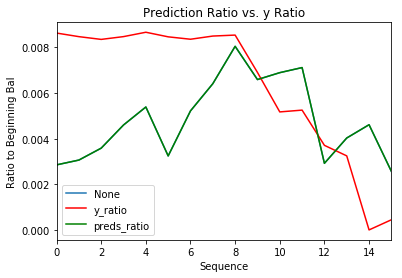

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 6
acc_order = preds_df.Account_Number.unique().tolist()
print('predictions')
print('-----------')
display(preds_df.loc[preds_df.Account_Number == validate_accounts[i]])
print('\nRMSE: ', loan_rmse[i],'\n')
print('Data')
print('----')
display(df[df.Account_Number == validate_accounts[i]])

print('\n----')
# get the first balance on file for the loan
bal_1 = df.loc[df.Account_Number == validate_accounts[i],'Balance_Owned_Participation'].reset_index(drop = True)[0]

y_ratio = np.array(preds_df.loc[preds_df.Account_Number == validate_accounts[i],'y'].astype(float))/ bal_1
print('y_ratio: \n',y_ratio)

preds_ratio = np.array(preds_df.loc[preds_df.Account_Number == validate_accounts[i],'Predictions'].astype(float))/ bal_1
print('preds ratio: \n',preds_ratio)
      
pd.Series(preds_ratio).plot()

seq_pos = [x for x in range(y_ratio.shape[0])]

plt.plot(seq_pos, y_ratio, 'b', color = 'red', label= 'y_ratio')
plt.plot(seq_pos, preds_ratio, 'b',color = 'green', label= 'preds_ratio')
plt.title('Prediction Ratio vs. y Ratio')
plt.xlabel('Sequence')
plt.ylabel('Ratio to Beginning Bal')
plt.legend()
plt.show()

In [55]:
preds_df.columns

Index(['Account_Number', 'Sequence', 'y', 'Predictions'], dtype='object')

In [56]:
# import pickle
# path = 'your_file_path'
# preds_df = pickle.load(open(path + 'preds_df.p','rb'))
# preds_df

## Expand upon the Preds_df Table

| Acct | Seq | y | y_hat | Beg_Bal | y_signal | preds_signal | y_binary | preds_binary |

In [57]:
group = preds_df.groupby('Account_Number')

def threshold_binary(x, thresh = .1):
    "Return binary flag based off of threshold"
    if x > thresh:
        return 1
    else:
        return 0
    
counter = 0
for account, sample in group:
    #Reset Index
    sample = sample.reset_index(drop = True)
    
    # Get the first balance on file for the loan
    bal_1 = df.loc[df.Account_Number == account,'Balance_Owned_Participation'].reset_index(drop = True)[0]
    
    # Add the begining balance
    sample['Beg_Bal'] = bal_1
    
    # add proportion of actual prepayment to beginning balance
    sample['y_Signal'] = np.array(sample['y'].astype(float))/ bal_1
    
    # add proportion of predicted value to begining balance
    sample['Preds_Signal'] = preds_ratio = np.array(sample['Predictions'].astype(float))/ bal_1
    
    # Create The Binary Flags
    sample['y_Binary'] = sample.y_Signal.apply(threshold_binary)
    sample['Preds_Binary'] = sample.Preds_Signal.apply(threshold_binary)
    
    # Reorder Data Frame
    sample = sample[['Sequence','Account_Number','Beg_Bal', 'y','Predictions', \
                     'y_Signal','Preds_Signal', 'y_Binary','Preds_Binary']]
    
    # Build out dataframe 
    if counter == 0:
        df_preds_analysis = sample
    else:
        df_preds_analysis = df_preds_analysis.append(sample)
     
    # add one to the counter    
    counter += 1

In [58]:
df_preds_analysis

,Sequence,Account_Number,Beg_Bal,y,Predictions,y_Signal,Preds_Signal,y_Binary,Preds_Binary
0,-2,100023328,52020.000,0.0,3696.742919921875,0.000,0.071,0,0
1,-1,100023328,52020.000,46669.94,25682.826171875,0.897,0.494,1,1
0,-5,10002499018,81000.000,813.56,897.9697265625,0.010,0.011,0,0
1,-4,10002499018,81000.000,677.92,301.34185791015625,0.008,0.004,0,0
2,-3,10002499018,81000.000,532.27,106.31011962890625,0.007,0.001,0,0
3,-2,10002499018,81000.000,378.68,24.36273193359375,0.005,0.000,0,0
4,-1,10002499018,81000.000,13753.5,14713.0546875,0.170,0.182,1,1
0,-2,100037042,60114.710,25.47,3696.742919921875,0.000,0.061,0,0
1,-1,100037042,60114.710,55521.29,26025.640625,0.924,0.433,1,1
0,-2,100050514,75397.630,0.0,3696.742919921875,0.000,0.049,0,0


In [59]:
def accuaracy_report(y_test, predictions):
    from sklearn.metrics import classification_report, confusion_matrix
    print('The Accuracy Score is: ',np.array(np.sum(np.equal(predictions, y_test))) / y_test.shape[0],'\n')
    print('The Classification Report')
    print('-------------------------')
    print(classification_report(y_test, predictions),'\n')
    print('The Confusion Matrix')
    print('-------------------------')
    print(pd.DataFrame(confusion_matrix(y_test, predictions)).apply(lambda x: x / sum(x), axis=1),'\n')
    print(['tn', 'fp', 'fn', 'tp'])
    print(confusion_matrix(y_test, predictions).ravel())

In [60]:
np.array(df_preds_analysis.y_Binary)
np.array(df_preds_analysis.Preds_Binary)

accuaracy_report(np.array(df_preds_analysis.y_Binary), np.array(df_preds_analysis.Preds_Binary))

The Accuracy Score is:  0.914022874192 

The Classification Report
-------------------------
             precision    recall  f1-score   support

          0       0.98      0.93      0.95     18980
          1       0.36      0.67      0.47      1130

avg / total       0.94      0.91      0.93     20110
 

The Confusion Matrix
-------------------------
      0     1
0 0.929 0.071
1 0.331 0.669 

['tn', 'fp', 'fn', 'tp']
[17625  1355   374   756]


# Bring In As Of Date and Payment Type
I will bring in the As Of Date and flags for Curtailment, Modifications, Refinances, and Payoffs. I will create a data frame with just this information and include the negative sequence as I did with the prediction analysis table. The two tables will be merged together on the account number and the sequence. 

In [61]:
# get account numbers in the prediction table
preds_acct = df_preds_analysis.Account_Number.unique()

# extract the prediction accounts from the origional dataframe
extract_df = df[df.Account_Number.isin(preds_acct)].copy()

# Create a flag for prepayment type
def prepay_flag(x):
    if x > 0:
        return 1
    else:
        return 0
    
# Create flags for prepayment
# ---------------------------------------------------------------
extract_df['Curtailment_Flag'] = extract_df.Curtailment.apply(prepay_flag)
extract_df['Modification_Flag'] = extract_df.Modification.apply(prepay_flag)
extract_df['Refinance_Flag'] = extract_df.Refinance.apply(prepay_flag)
extract_df['PayOff_Flag'] = extract_df.PayOff.apply(prepay_flag)


# choose columns to select
select_cols = ['Account_Number','Sequence','As_Of_Date','Curtailment_Flag',
               'Modification_Flag','Refinance_Flag','PayOff_Flag']

# group by account number
groups = extract_df.groupby('Account_Number')

# Iterate through the groupings to add the sequences and extract
# the as of dates and prepayment flags. 
#----------------------------------------------------------------
counter = 0
for account, subset in groups:
    # add a column that gets the sequences
    subset['Sequence'] = [x for x in range(-subset.shape[0],0,1)]
    # build out df
    if counter == 0:
        seq_dates = subset[select_cols].copy()
        counter += 1
    else:
        seq_dates = seq_dates.append(subset[select_cols])
        
seq_dates

C:\Users\thomb\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Account_Number,Sequence,As_Of_Date,Curtailment_Flag,Modification_Flag,Refinance_Flag,PayOff_Flag
106003,100023328,-3,2012-12-31,0,0,0,0
118901,100023328,-2,2013-03-31,0,0,0,0
121680,100023328,-1,2013-06-30,0,0,0,1
117471,10002499018,-6,2013-03-31,1,0,0,0
126252,10002499018,-5,2013-06-30,1,0,0,0
134798,10002499018,-4,2013-09-30,1,0,0,0
135889,10002499018,-3,2013-12-31,1,0,0,0
147578,10002499018,-2,2014-03-31,1,0,0,0
153384,10002499018,-1,2014-06-30,0,0,0,1
106004,100037042,-3,2012-12-31,0,0,0,0


## Join The Prediction Analysis Data Frame with the Seq_dates

In [62]:
print('Preds Analysis DF')
print('-----------------')
print(df_preds_analysis.info())
print('\nSeq Dates DF')
print('-----------------')
seq_dates.info()

Preds Analysis DF
-----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20110 entries, 0 to 15
Data columns (total 9 columns):
Sequence          20110 non-null object
Account_Number    20110 non-null object
Beg_Bal           20110 non-null float64
y                 20110 non-null object
Predictions       20110 non-null object
y_Signal          20110 non-null float64
Preds_Signal      20110 non-null float64
y_Binary          20110 non-null int64
Preds_Binary      20110 non-null int64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.5+ MB
None

Seq Dates DF
-----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27394 entries, 106003 to 257001
Data columns (total 7 columns):
Account_Number       27394 non-null object
Sequence             27394 non-null int64
As_Of_Date           27394 non-null datetime64[ns]
Curtailment_Flag     27394 non-null int64
Modification_Flag    27394 non-null int64
Refinance_Flag       27394 non-null int64
PayOff_Flag          27

In [63]:
# Convert Sequence to a string in seq dates df
seq_dates.Sequence = seq_dates.Sequence.astype(str)
print('The shape before merging: ',df_preds_analysis.shape)
df_preds_analysis = df_preds_analysis.merge(seq_dates, how = 'left', on =['Account_Number', 'Sequence'])
print('The shape after merging: ',df_preds_analysis.shape)
df_preds_analysis

The shape before merging:  (20110, 9)
The shape after merging:  (20110, 14)


,Sequence,Account_Number,Beg_Bal,y,Predictions,y_Signal,Preds_Signal,y_Binary,Preds_Binary,As_Of_Date,Curtailment_Flag,Modification_Flag,Refinance_Flag,PayOff_Flag
0,-2,100023328,52020.000,0.0,3696.742919921875,0.000,0.071,0,0,2013-03-31,0,0,0,0
1,-1,100023328,52020.000,46669.94,25682.826171875,0.897,0.494,1,1,2013-06-30,0,0,0,1
2,-5,10002499018,81000.000,813.56,897.9697265625,0.010,0.011,0,0,2013-06-30,1,0,0,0
3,-4,10002499018,81000.000,677.92,301.34185791015625,0.008,0.004,0,0,2013-09-30,1,0,0,0
4,-3,10002499018,81000.000,532.27,106.31011962890625,0.007,0.001,0,0,2013-12-31,1,0,0,0
5,-2,10002499018,81000.000,378.68,24.36273193359375,0.005,0.000,0,0,2014-03-31,1,0,0,0
6,-1,10002499018,81000.000,13753.5,14713.0546875,0.170,0.182,1,1,2014-06-30,0,0,0,1
7,-2,100037042,60114.710,25.47,3696.742919921875,0.000,0.061,0,0,2013-03-31,1,0,0,0
8,-1,100037042,60114.710,55521.29,26025.640625,0.924,0.433,1,1,2013-06-30,0,0,0,1
9,-2,100050514,75397.630,0.0,3696.742919921875,0.000,0.049,0,0,2013-03-31,0,0,0,0


The final addition that I want to add to the table before I begin evaluating the table is to filter the raw predictions. I want to be able to visualize the predictions at a portfolio level. However, because of the 'smaller' constant prepayments when there is no prepayment, I expect the aggregate predicted prepayment will be much higher. To compensate for this, I will only allow the predictions through if preds_binary is 1.

In [64]:
filtered_preds = []

# round the prediction
df_preds_analysis.Predictions = df_preds_analysis.Predictions.astype(float).round(1)

for i in range(df_preds_analysis.shape[0]):
    if df_preds_analysis.Preds_Binary[i] == 1:
        filtered_preds.append(df_preds_analysis.Predictions[i])
    else:
        filtered_preds.append(0)
        
df_preds_analysis['Filtered_Preds'] = filtered_preds
df_preds_analysis

,Sequence,Account_Number,Beg_Bal,y,Predictions,y_Signal,Preds_Signal,y_Binary,Preds_Binary,As_Of_Date,Curtailment_Flag,Modification_Flag,Refinance_Flag,PayOff_Flag,Filtered_Preds
0,-2,100023328,52020.000,0.0,3696.700,0.000,0.071,0,0,2013-03-31,0,0,0,0,0.000
1,-1,100023328,52020.000,46669.94,25682.800,0.897,0.494,1,1,2013-06-30,0,0,0,1,25682.800
2,-5,10002499018,81000.000,813.56,898.000,0.010,0.011,0,0,2013-06-30,1,0,0,0,0.000
3,-4,10002499018,81000.000,677.92,301.300,0.008,0.004,0,0,2013-09-30,1,0,0,0,0.000
4,-3,10002499018,81000.000,532.27,106.300,0.007,0.001,0,0,2013-12-31,1,0,0,0,0.000
5,-2,10002499018,81000.000,378.68,24.400,0.005,0.000,0,0,2014-03-31,1,0,0,0,0.000
6,-1,10002499018,81000.000,13753.5,14713.100,0.170,0.182,1,1,2014-06-30,0,0,0,1,14713.100
7,-2,100037042,60114.710,25.47,3696.700,0.000,0.061,0,0,2013-03-31,1,0,0,0,0.000
8,-1,100037042,60114.710,55521.29,26025.600,0.924,0.433,1,1,2013-06-30,0,0,0,1,26025.600
9,-2,100050514,75397.630,0.0,3696.700,0.000,0.049,0,0,2013-03-31,0,0,0,0,0.000


I want to add a column that captures all of the prepayment types in one column instead of having the flags. I will use this as a filter in tableau for visualizations.

In [65]:
cols = ['Curtailment_Flag','Modification_Flag','Refinance_Flag','PayOff_Flag']
values = ['Curtailment', 'Modification','Refinance','PayOff']

df_preds_analysis['Prepay_Type'] = 'None'
for index, col in enumerate(cols):
    df_preds_analysis.loc[df_preds_analysis[col]==1,'Prepay_Type'] = values[index]

In [66]:
df_preds_analysis

,Sequence,Account_Number,Beg_Bal,y,Predictions,y_Signal,Preds_Signal,y_Binary,Preds_Binary,As_Of_Date,Curtailment_Flag,Modification_Flag,Refinance_Flag,PayOff_Flag,Filtered_Preds,Prepay_Type
0,-2,100023328,52020.000,0.0,3696.700,0.000,0.071,0,0,2013-03-31,0,0,0,0,0.000,None
1,-1,100023328,52020.000,46669.94,25682.800,0.897,0.494,1,1,2013-06-30,0,0,0,1,25682.800,PayOff
2,-5,10002499018,81000.000,813.56,898.000,0.010,0.011,0,0,2013-06-30,1,0,0,0,0.000,Curtailment
3,-4,10002499018,81000.000,677.92,301.300,0.008,0.004,0,0,2013-09-30,1,0,0,0,0.000,Curtailment
4,-3,10002499018,81000.000,532.27,106.300,0.007,0.001,0,0,2013-12-31,1,0,0,0,0.000,Curtailment
5,-2,10002499018,81000.000,378.68,24.400,0.005,0.000,0,0,2014-03-31,1,0,0,0,0.000,Curtailment
6,-1,10002499018,81000.000,13753.5,14713.100,0.170,0.182,1,1,2014-06-30,0,0,0,1,14713.100,PayOff
7,-2,100037042,60114.710,25.47,3696.700,0.000,0.061,0,0,2013-03-31,1,0,0,0,0.000,Curtailment
8,-1,100037042,60114.710,55521.29,26025.600,0.924,0.433,1,1,2013-06-30,0,0,0,1,26025.600,PayOff
9,-2,100050514,75397.630,0.0,3696.700,0.000,0.049,0,0,2013-03-31,0,0,0,0,0.000,None


In [ ]:
path = 'your_file_path/Pickles/'
df_preds_analysis.to_csv(path + 'df_preds_analysis.csv', index= False)
pickle.dump(df_preds_analysis, open(path + 'df_preds_analysis.p','wb'))

# Evaluate the table
I want to determine the following:
1. What the predictions look like for each prepay type
2. Does our binary for y capture all of the major prepayment: Payoff, Modification, Refinance
<br>
<br>
prior to evaluating each section I want to see what the preds_signal distribution is for those that had no prepayment activity at all. Knowing this upfront will tell us how we can tweak the threshold to achieve better predictions in this segment.

In [68]:
df_preds_analysis.loc[df_preds_analysis.Prepay_Type == 'None', 'Preds_Signal'].describe(dec)

NameError: name 'dec' is not defined

## Payoffs

In [69]:
po = df_preds_analysis[df_preds_analysis.PayOff_Flag == 1].copy()

In [70]:
po.y_Binary.value_counts()

1    746
0     73
Name: y_Binary, dtype: int64

In [71]:
po.loc[po.y_Binary ==0].shape

(73, 16)

In [72]:
dec = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
po.loc[po.y_Binary ==0,'Preds_Signal'].describe(dec)

count   73.000
mean     0.066
std      0.121
min      0.004
10%      0.008
20%      0.012
30%      0.016
40%      0.027
50%      0.032
60%      0.041
70%      0.059
80%      0.076
90%      0.136
max      0.936
Name: Preds_Signal, dtype: float64

In [73]:
po.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 819 entries, 1 to 20109
Data columns (total 16 columns):
Sequence             819 non-null object
Account_Number       819 non-null object
Beg_Bal              819 non-null float64
y                    819 non-null object
Predictions          819 non-null float64
y_Signal             819 non-null float64
Preds_Signal         819 non-null float64
y_Binary             819 non-null int64
Preds_Binary         819 non-null int64
As_Of_Date           819 non-null datetime64[ns]
Curtailment_Flag     819 non-null int64
Modification_Flag    819 non-null int64
Refinance_Flag       819 non-null int64
PayOff_Flag          819 non-null int64
Filtered_Preds       819 non-null float64
Prepay_Type          819 non-null object
dtypes: datetime64[ns](1), float64(5), int64(6), object(4)
memory usage: 108.8+ KB


In [74]:
print('Accuracy Report for Only Payoffs')
accuaracy_report(np.array(po.PayOff_Flag), np.array(po.Preds_Binary))

Accuracy Report for Only Payoffs
The Accuracy Score is:  0.782661782662 

The Classification Report
-------------------------
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.78      0.88       819

avg / total       1.00      0.78      0.88       819
 

The Confusion Matrix
-------------------------
      0     1
0   nan   nan
1 0.217 0.783 

['tn', 'fp', 'fn', 'tp']
[  0   0 178 641]


C:\Users\thomb\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
